### Steps to run this
- conda install -c nvidia -c conda-forge -c legate cunumeric
- conda install pandas numpy scipy
- conda install notebook
- legate-jupyter --cpus 4 --gpus 1
- jupyter notebook --no-browser
- Open this notebook, select the corresponding env and then select the kernel "Legate_SM_GPU"

In [1]:
import cunumeric as cun
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from IPython.display import display, clear_output

In [2]:
arr_sizes = [20, 50, 100, 150, 512, 1024, 2048, 6000]

In [3]:
def plot_graph(np_times, cun_times, title,
               sizes = arr_sizes,
               x_lim = None,
               y_lim = None,
               show_matrix_size = False):
    plt.plot(sizes, np_times, label='Numpy')
    plt.plot(sizes, cun_times, label='CuNumeric')
    plt.xlabel('Array Size')
    plt.ylabel('Time (s)')
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    if show_matrix_size:
        # In x-axis, display the array sizes as 250x250, 500x500, etc.
        plt.xticks(sizes, [f'{size}x{size}' for size in sizes])
    plt.legend()
    plt.grid()
    plt.show()

# Matrix multiplication

In [4]:
# Using numpy
np_times = []
for size in arr_sizes:
    import timeit
    a = np.random.rand(size, size)
    b = np.random.rand(size, size)
    start_time = time.time()
    c = np.multiply(a, b)
    end_time = time.time()
    np_times.append(end_time - start_time)

# Using cunumeric
cun_times = []
for size in arr_sizes:
    a = cun.random.rand(size, size)
    b = cun.random.rand(size, size)
    start_time = time.time()
    c = cun.multiply(a, b)
    end_time = time.time()
    cun_times.append(end_time - start_time)

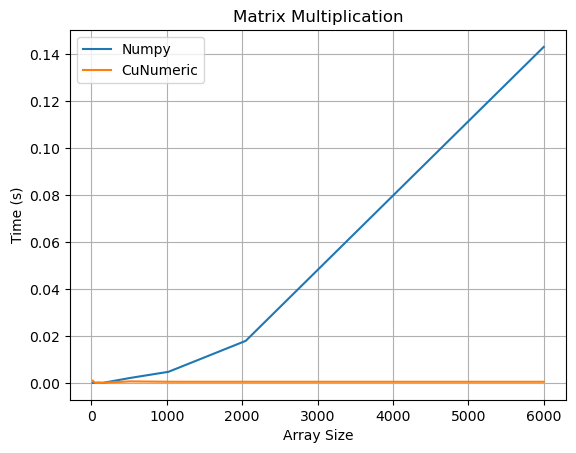

In [5]:
plot_graph(np_times, cun_times, 'Matrix Multiplication')

# Transpose of a matrix

In [6]:
# Using numpy
np_times = []
for size in arr_sizes:
    a = np.random.rand(size, size)
    start_time = time.time()
    c = np.transpose(a)
    end_time = time.time()
    np_times.append(end_time - start_time)

# Using cunumeric
cun_times = []
for size in arr_sizes:
    a = cun.random.rand(size, size)
    start_time = time.time()
    c = cun.transpose(a)
    end_time = time.time()
    cun_times.append(end_time - start_time)

In [7]:
arr_sizes

[20, 50, 100, 150, 512, 1024, 2048, 6000]

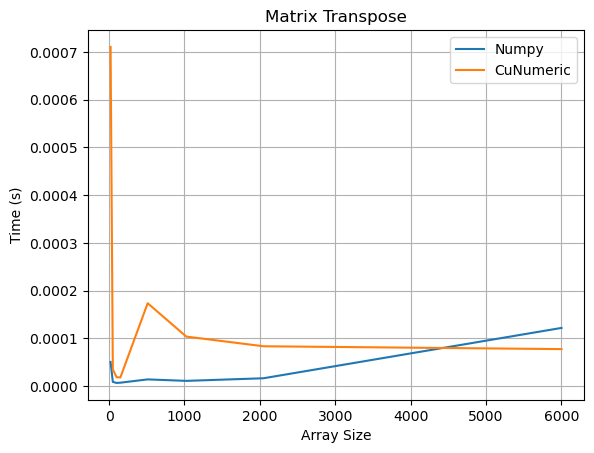

In [8]:
plot_graph(np_times, cun_times, 'Matrix Transpose')

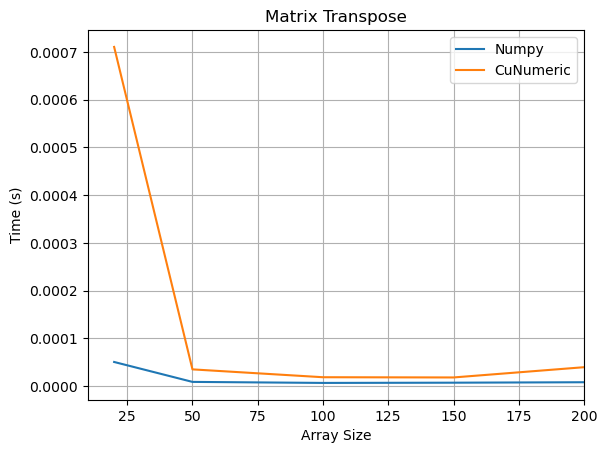

In [9]:
plot_graph(np_times, cun_times, 'Matrix Transpose', 
           x_lim=(10, 200))

# FFT2

In [5]:
arr_sizes_fft = [20, 50, 100, 150, 512, 1024, 2048]

In [6]:
# Using numpy
np_times = []
for size in arr_sizes_fft:
    a = np.random.rand(size, size)
    start_time = time.time()
    b = np.fft.fft2(a)
    end_time = time.time()
    np_times.append(end_time - start_time)

# Using cunumeric
cun_times = []
for size in arr_sizes_fft:
    a = cun.random.rand(size, size)
    start_time = time.time()
    b = cun.fft.fft2(a)
    end_time = time.time()
    cun_times.append(end_time - start_time)

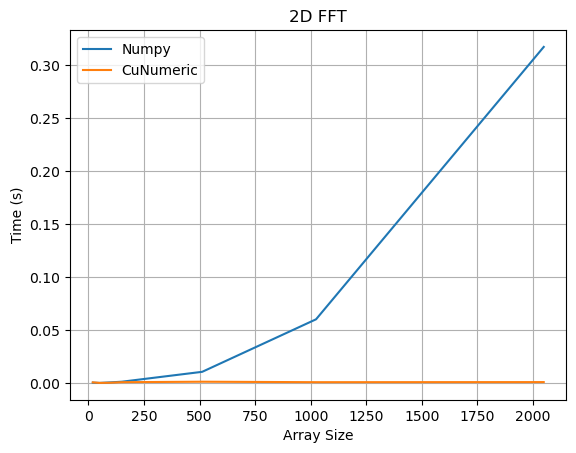

In [7]:
plot_graph(np_times, cun_times, '2D FFT', sizes=arr_sizes_fft)

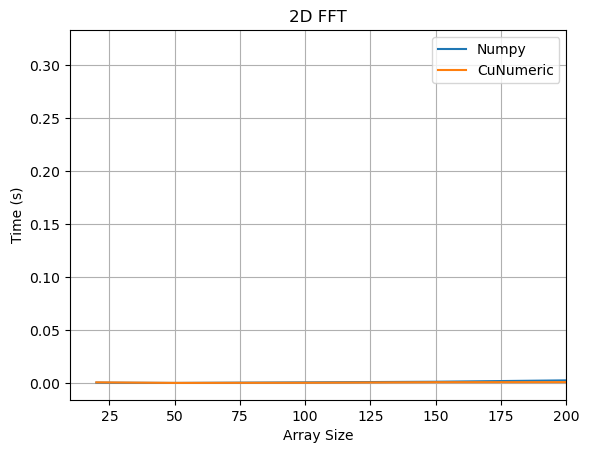

In [8]:
plot_graph(np_times, cun_times, '2D FFT', sizes=arr_sizes_fft,
        x_lim=(10, 200))

# Spinodal decomposition using numpy

Non-vectorized code

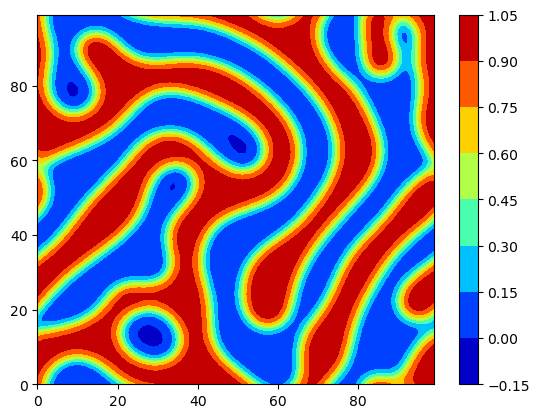


Execution Time: 7.939823150634766 seconds


In [34]:
#size of the box
Nx = 100
Ny = 100
#Initial composition 
c = 0.5*np.ones([Nx,Ny])
#Noise - seed (mimic thermal fluctuations) 
np.random.seed(1024)
random_num = np.random.normal(0,0.01,(Nx,Ny))

c = c - random_num


X,Y = np.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

dx = 1.0
dy = 1.0
dt = 0.5
cnew = c
#delkx is grid spacing along kx in Fourier space
#delky is grid spacing along ky in Fourier space

delkx = 2*np.pi/(Nx*dx)
delky = 2*np.pi/(Ny*dy)

#A is the prefactor of free energy f = A (c**2) * (1-c)**2
#A is inversely proportional to temperature

A = 1 

#M is the scaled constant mobility where diffusivity D = M (d^2f/dc^2) 
M = 1

# kappa is the scaled gradient energy coefficient (interfacial energy)
kappa = 1

# Start time
start_time = time.time()

# Outer iterations of 1000
for m in range(5):
    # Inner iterations of 100
    for n in range(100):
        
        #g stores the first derivative of free energy df/dc = 2*A*c*(1-c)*(1-2c)
        mult = np.multiply(1-cnew,1-2*cnew)
        g = 2*A*np.multiply(cnew,mult)
        ghat = np.fft.fft2(g)
        chat = np.fft.fft2(cnew)
        
        for i in range(Nx):
            if i <= Nx/2:
                kx = i*delkx
            else:
                kx = (i-Nx)*delkx
            for j in range(Ny):
                if j <= Ny/2:
                    ky = j*delky
                else:
                    ky = (j-Ny)*delky
                    
                k2 = kx**2 + ky**2
                k4 = k2**2
                chat[i,j] = (chat[i,j] - M*dt*k2*ghat[i,j])/(1+2*M*kappa*k4*dt)
                
        cnew = np.fft.ifft2(chat).real
        c = cnew
    print(m)
    # Clear the previous plot and plot the new composition
    # clear_output(wait=True)
    # X,Y = np.meshgrid(range(Nx),range(Ny))        
    # plt.contourf(X,Y,cnew,cmap = 'jet')
    # plt.colorbar()
    # plt.show()
    # End time
end_time = time.time()

clear_output(wait=True)
X,Y = np.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

# Calculate and print the execution time
execution_time = end_time - start_time
print("\nExecution Time:", execution_time, "seconds")

Vectorized code

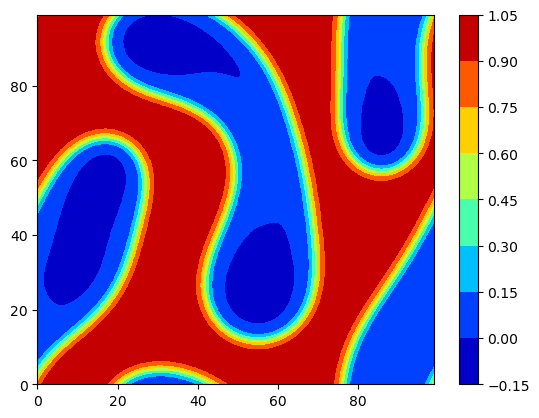

Execution Time: 3.4338865280151367 seconds


In [36]:
#size of the box
Nx = 100
Ny = 100
#Initial composition
c = 0.5*np.ones([Nx,Ny])
#Noise - seed (mimic thermal fluctuations) 
np.random.seed(1024)
random_num = np.random.normal(0,0.01,(Nx,Ny))

c = c - random_num


X,Y = np.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

dx = 1.0
dy = 1.0
dt = 0.5
cnew = c
#delkx is grid spacing along kx in Fourier space
#delky is grid spacing along ky in Fourier space

delkx = 2*np.pi/(Nx*dx)
delky = 2*np.pi/(Ny*dy)

#A is the prefactor of free energy f = A (c**2) * (1-c)**2
#A is inversely proportional to temperature

A = 1 

#M is the scaled constant mobility where diffusivity D = M (d^2f/dc^2) 
M = 1

# kappa is the scaled gradient energy coefficient (interfacial energy)
kappa = 1

# Start time
start_time = time.time()

i_indices = np.arange(Nx) # Numbers from [0 to Nx-1]
j_indices = np.arange(Ny) # Numbers from [0 to Ny-1]

kx = np.where(i_indices <= Nx/2, i_indices * delkx, (i_indices - Nx) * delkx)
# If i <= Nx/2, kx = i*delkx, else kx = (i-Nx)*delkx
ky = np.where(j_indices <= Ny/2, j_indices * delky, (j_indices - Ny) * delky)
# If j <= Ny/2, ky = j*delky, else ky = (j-Ny)*delky

# Calculate k2 and k4
# kx[:, np.newaxis] will reshape it to (Nx, 1)
# ky[np.newaxis, :] will reshape it to (1, Ny)
# Their squared addition will result in a (Nx, Ny) matrix
# k2[first row] = [kx[0]**2 + ky[0]**2, kx[0]**2 + ky[1]**2, ..., kx[0]**2 + ky[Ny-1]**2]
k2 = kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2
k4 = k2**2

# Outer iterations of 1000
for m in range(50):
    # Inner iterations of 100
    for n in range(100):
        
        #g stores the first derivative of free energy df/dc = 2*A*c*(1-c)*(1-2c)
        mult = np.multiply(1-cnew,1-2*cnew)
        g = 2*A*np.multiply(cnew,mult)
        ghat = np.fft.fft2(g)
        chat = np.fft.fft2(cnew)
        
        chat = (chat - M*dt*k2*ghat)/(1+2*M*kappa*k4*dt)
                
        cnew = np.fft.ifft2(chat).real
        c = cnew
    print(m)
    # Clear the previous plot and plot the new composition
    # clear_output(wait=True)
    # X,Y = np.meshgrid(range(Nx),range(Ny))        
    # plt.contourf(X,Y,cnew,cmap = 'jet')
    # plt.colorbar()
    # plt.show()
    # End time
end_time = time.time()

clear_output(wait=True)
X,Y = np.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

# Calculate and print the execution time
execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

# Spinodal decomposition using cunumeric

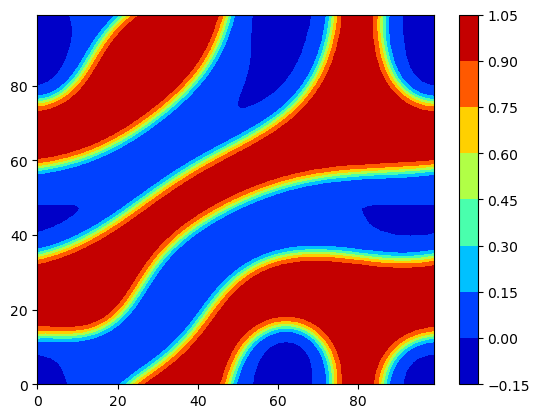


Execution Time: 11.678458213806152 seconds


In [33]:
#size of the box
Nx = 100
Ny = 100
#Initial composition 
c = 0.5*cun.ones([Nx,Ny])
#Noise - seed (mimic thermal fluctuations) 
cun.random.seed(1024)
random_num = cun.random.normal(0,0.01,(Nx,Ny))

c = c - random_num


X,Y = cun.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

dx = 1.0
dy = 1.0
dt = 0.5
cnew = c
#delkx is grid spacing along kx in Fourier space
#delky is grid spacing along ky in Fourier space

delkx = 2*cun.pi/(Nx*dx)
delky = 2*cun.pi/(Ny*dy)

#A is the prefactor of free energy f = A (c**2) * (1-c)**2
#A is inversely proportional to temperature

A = 1 

#M is the scaled constant mobility where diffusivity D = M (d^2f/dc^2) 
M = 1

# kappa is the scaled gradient energy coefficient (interfacial energy)
kappa = 1

# Start time
start_time = time.time()

i_indices = cun.arange(Nx) # Numbers from [0 to Nx-1]
j_indices = cun.arange(Ny) # Numbers from [0 to Ny-1]

kx = cun.where(i_indices <= Nx/2, i_indices * delkx, (i_indices - Nx) * delkx)
# If i <= Nx/2, kx = i*delkx, else kx = (i-Nx)*delkx
ky = cun.where(j_indices <= Ny/2, j_indices * delky, (j_indices - Ny) * delky)
# If j <= Ny/2, ky = j*delky, else ky = (j-Ny)*delky

# Calculate k2 and k4
# kx[:, np.newaxis] will reshape it to (Nx, 1)
# ky[np.newaxis, :] will reshape it to (1, Ny)
# Their squared addition will result in a (Nx, Ny) matrix
# k2[first row] = [kx[0]**2 + ky[0]**2, kx[0]**2 + ky[1]**2, ..., kx[0]**2 + ky[Ny-1]**2]
k2 = kx[:, cun.newaxis]**2 + ky[cun.newaxis, :]**2
k4 = k2**2

# Outer iterations of 1000
for m in range(50):
    # Inner iterations of 100
    for n in range(100):
        
        #g stores the first derivative of free energy df/dc = 2*A*c*(1-c)*(1-2c)
        mult = cun.multiply(1-cnew,1-2*cnew)
        g = 2*A*cun.multiply(cnew,mult)
        ghat = cun.fft.fft2(g)
        chat = cun.fft.fft2(cnew)

        chat = (chat - M*dt*k2*ghat)/(1+2*M*kappa*k4*dt)
                
        cnew = cun.fft.ifft2(chat).real
        c = cnew
    print(m)
    # Clear the previous plot and plot the new composition
    # clear_output(wait=True)
    # X,Y = np.meshgrid(range(Nx),range(Ny))        
    # plt.contourf(X,Y,cnew,cmap = 'jet')
    # plt.colorbar()
    # plt.show()
    # End time
end_time = time.time()

clear_output(wait=True)
X,Y = cun.meshgrid(range(Nx),range(Ny))        
plt.contourf(X,Y,c,cmap = 'jet')
plt.colorbar()
plt.show()

# Calculate and print the execution time
execution_time = end_time - start_time
print("\nExecution Time:", execution_time, "seconds")